In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
import json
with open('./combined_labeled_sentences.json', 'r', encoding='utf-8') as f:
  dataset=json.load(f)

In [4]:
dataset_train = {x:dataset[x] for x in ['abt22_sentences.json', 'abt23_sentences.json', 'dal22_sentences.json', 'dal23_sentences.json', 'ehc22_sentences.json', 'ehc23_sentences.json', 'f22_sentences.json', 'f23_sentences.json', 'fdx22_sentences.json', 'fdx23_sentences.json', 'holx22_sentences.json', 'holx23_sentences.json', 'ogn22_sentences.json', 'ogn23_sentences.json', 'tsla22_sentences.json', 'ups22_sentences.json']}
dataset_test1 = {x:dataset[x] for x in ['tsla23_sentences.json',  'ups23_sentences.json']} 
dataset_test2 = {x:dataset[x] for x in ['zbh22_sentences.json', 'zbh23_sentences.json']} 

import pandas as pd

dataset_train_list = []
for kulcs in dataset_train:
  for elements in dataset_train[kulcs]:
    dataset_train_list.append(elements)
    
dataset_test_list1 = []
for kulcs in dataset_test1:
  for elements in dataset_test1[kulcs]:
    dataset_test_list1.append(elements)

dataset_test_list2 = []
for kulcs in dataset_test2:
  for elements in dataset_test2[kulcs]:
    dataset_test_list2.append(elements)
    
df_train=pd.DataFrame(dataset_train_list, columns=['text', 'label'])
df_test1=pd.DataFrame(dataset_test_list1, columns=['text', 'label'])
df_test2=pd.DataFrame(dataset_test_list2, columns=['text', 'label'])

In [5]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float).unsqueeze(0)
        }


In [6]:
model_name = "yiyanghkust/finbert-tone"
model = torch.load('FullTrain2best')
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

C:\Users\Jozsef\anaconda3\envs\finms\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
sum(p.numel() for p in model.parameters())

109801089

In [9]:
for param in model.parameters():
    param.requires_grad = False

In [10]:
model.problem_type='multi_label_classification'
model.config.problem_type='multi_label_classification'

In [11]:
for param in model.classifier.parameters():
    param.requires_grad = False

In [40]:
df_train=df_train.sample(frac=1)

train_data = CustomDataset(
    texts=df_train['text'].tolist()[:],
    labels=df_train['label'].tolist()[:],
    tokenizer=tokenizer,
    max_len=256
)

val_data = CustomDataset(
    texts=df_train['text'].tolist()[35000:],
    labels=df_train['label'].tolist()[35000:],
    tokenizer=tokenizer,
    max_len=256
)

test_data1 = CustomDataset(
    texts=df_test1['text'].tolist(),
    labels=df_test1['label'].tolist(),
    tokenizer=tokenizer,
    max_len=256
)

test_data2 = CustomDataset(
    texts=df_test2['text'].tolist(),
    labels=df_test2['label'].tolist(),
    tokenizer=tokenizer,
    max_len=256
)

train_dataloader = DataLoader(train_data, batch_size=512, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=512, shuffle=False)
test1_dataloader = DataLoader(test_data1, batch_size=512, shuffle=False)
test2_dataloader = DataLoader(test_data2, batch_size=512, shuffle=False)

In [41]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(p):
    preds = p.predictions
    preds = torch.sigmoid(torch.tensor(preds)).numpy() > 0.5
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [42]:
model.to('cuda')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [43]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [44]:
def predict(model, dataloader):
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.sigmoid(logits).cpu().numpy()
            predictions.extend(preds)
    return [x[0] for x in predictions]

In [45]:
val_data

In [46]:
predictions_train = predict(model, train_dataloader)
predictions_test1 = predict(model, test1_dataloader)
predictions_test2 = predict(model, test2_dataloader)

In [54]:
predictions_train = np.array(predictions_train)

In [55]:
predictions_test1 = np.array(predictions_test1)
predictions_test2 = np.array(predictions_test2)

In [61]:
labels_train=df_train.label
labels_test1=df_test1.label
labels_test2=df_test2.label

In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

In [99]:
def print_metrics(predictions, labels, set_name):
    accuracy = accuracy_score(labels, predictions>0.9)
    precision = precision_score(labels, predictions>0.9)
    recall = recall_score(labels, predictions>0.9)
    f1 = f1_score(labels, predictions>0.9)
    roc_auc = roc_auc_score(labels, predictions)
    average_prec = average_precision_score(labels, predictions)

    print(f"Metrics for {set_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"AVG-PREC: {average_prec:.4f}")
    print()

In [100]:
print_metrics(predictions_train, labels_train, "Training Set")
print_metrics(predictions_test1, labels_test1, "Test Set 1")
print_metrics(predictions_test2, labels_test2, "Test Set 2")

Metrics for Training Set:
Accuracy: 0.9374
Precision: 0.8953
Recall: 0.7767
F1-Score: 0.8318
ROC-AUC: 0.9770
AVG-PREC: 0.9250

Metrics for Test Set 1:
Accuracy: 0.9190
Precision: 0.8387
Recall: 0.7609
F1-Score: 0.7979
ROC-AUC: 0.9590
AVG-PREC: 0.8919

Metrics for Test Set 2:
Accuracy: 0.9193
Precision: 0.8343
Recall: 0.7362
F1-Score: 0.7822
ROC-AUC: 0.9563
AVG-PREC: 0.8725



In [101]:
import plotly.express as px

In [105]:
dfResults=pd.DataFrame({
    'accuracy': [0.9374, 0.9190, 0.9193],
    'precision': [0.8953, 0.8387, 0.8343],
    'recall': [0.7767, 0.7609, 0.7362],
    'f1_score': [0.8318, 0.7979, 0.7822],
    'roc_auc': [0.9770, 0.9590, 0.9563],
    'avg_prec': [0.9250, 0.8919, 0.8725],
    'set': ['Train', 'Test1', 'Test2']
})

In [106]:
dfResults

,accuracy,precision,recall,f1_score,roc_auc,avg_prec,set
0,0.9374,0.8953,0.7767,0.8318,0.9770,0.9250,Train
1,0.9190,0.8387,0.7609,0.7979,0.9590,0.8919,Test1
2,0.9193,0.8343,0.7362,0.7822,0.9563,0.8725,Test2


In [107]:
df_tall = pd.melt(dfResults, id_vars=['set'], var_name='metric', value_name='value')

df_tall.reset_index(inplace=True, drop=True)

df_tall

,set,metric,value
0,Train,accuracy,0.9374
1,Test1,accuracy,0.9190
2,Test2,accuracy,0.9193
3,Train,precision,0.8953
4,Test1,precision,0.8387
5,Test2,precision,0.8343
6,Train,recall,0.7767
7,Test1,recall,0.7609
8,Test2,recall,0.7362
9,Train,f1_score,0.8318


In [108]:
import plotly.io as pio
pio.renderers.default = 'iframe'

In [119]:
color_discrete_map = {
    'Train': 'rgb(232, 144, 21)',
    'Test1': 'rgb(0, 143, 232)',
    'Test2': 'rgb(2, 112, 181)'
}
fig = px.bar(df_tall, x='metric', y='value', color='set', barmode='group', color_discrete_map=color_discrete_map, labels={'set':'Dataset', 'metric':'Metric', 'value':'Performance'})
fig.write_html('BertRelevancePerformance.html')
fig.show()

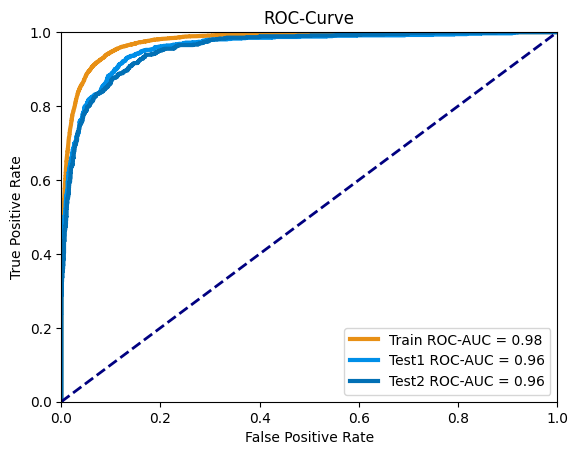

In [140]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


def plot_roc_curve(probabilitiess, labelss, set_names, colors):
    plt.figure()
    for ind in range(len(probabilitiess)):
        fpr, tpr, _ = roc_curve(labelss[ind], probabilitiess[ind])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[ind], lw=3, label=f'{set_names[ind]} ROC-AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-Curve')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curves for each set
plot_roc_curve([predictions_train, predictions_test1, predictions_test2], [labels_train, labels_test1, labels_test2], ["Train", "Test1", "Test2"], colors=[(232/255, 144/255, 21/255), (0/255, 143/255, 232/255), (2/255, 112/255, 181/255)])

In [141]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


def plot_roc_curve(probabilitiess, labelss, set_names, colors):
    plt.figure()
    for ind in range(len(probabilitiess)):
        fpr, tpr, _ = precision_recall_curve(labelss[ind], probabilitiess[ind])
        roc_auc = average_precision_score(labelss[ind], probabilitiess[ind])
        plt.plot(fpr, tpr, color=colors[ind], lw=3, label=f'{set_names[ind]} AVG-PREC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision - Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

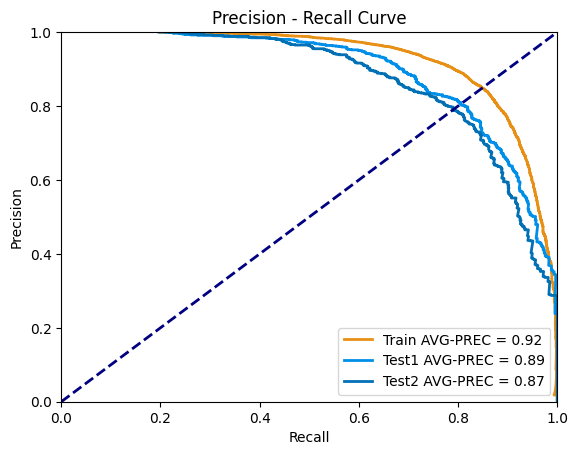

In [139]:
plot_roc_curve([predictions_train, predictions_test1, predictions_test2], [labels_train, labels_test1, labels_test2], ["Train", "Test1", "Test2"], colors=[(232/255, 144/255, 21/255), (0/255, 143/255, 232/255), (2/255, 112/255, 181/255)])

In [145]:
df_test2

,text,label
0,ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...,0
1,(Exact name of registrant as specified in its ...,0
2,...,0
3,Securities registered pursuant to Section 12(b...,0
4,Title of each class...,0
...,...,...
4058,Pursuant to the requirements of the Securities...,0
4059,Chief Financial Officer and Executive Vice P...,0
4060,/s/ Paul Stellato ...,0
4061,/s/ Maria Teresa Hilado ...,0
